In [1]:
from functools import partial

from matplotlib import pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

import torch

torch.set_printoptions(linewidth=400, threshold=100000)

import sys

sys.path.append("../..")

from mlstm_kernels.components.ln import MultiHeadLayerNorm
from mlstm_kernels.mlstm.chunkwise.max_triton_fwbw_v3 import (
    mlstm_chunkwise_max_triton_v3,
)

import torch.nn.functional as F

# mLSTM Signal Propagation analysis

In large scale experiments the mLSTM was instable. Philipp found that the mLSTM increases the min and max of the h output compared to the qkv input. 

In this notebook we reproduce this phenomenum just with the mLSTM operation and random normal inputs.
We compare against causal attention and Linear attention. 

In [3]:
DTYPE = torch.bfloat16  # torch.bfloat16
DEVICE = torch.device("cuda:0")

## Part 1: Initial Analysis

In [4]:
# params
S = 512  # seq len
B = 1  # batch size
NH = 1  # num heads
DHQK = 32  # dim per head
DHV = 32  # dim per head

EPS = 0.0

vecI_offset = 0.0
vecF_offset = 6.0

In [5]:
torch.manual_seed(0)
matQ = torch.randn((B, NH, S, DHQK), dtype=DTYPE, device=DEVICE)
matK = torch.randn((B, NH, S, DHQK), dtype=DTYPE, device=DEVICE)
matV = torch.randn((B, NH, S, DHV), dtype=DTYPE, device=DEVICE)
vecI = vecI_offset + torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)
vecF = vecF_offset + torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)
# vecI = 0.00001 * torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)
# vecF = -30. + torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)

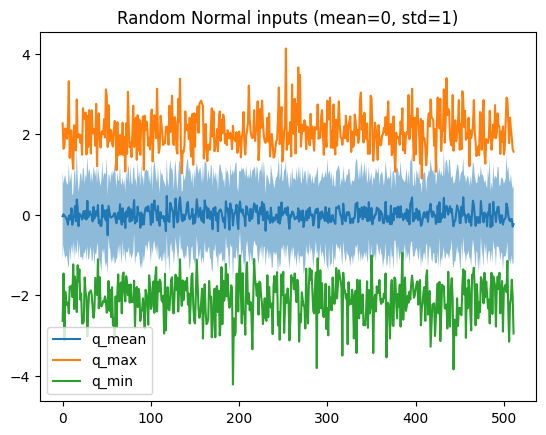

In [6]:
# plot qkv
q_pl_mean = matQ.mean(-1).flatten().cpu().float().numpy()
q_pl_std = matQ.std(-1).flatten().cpu().float().numpy()
q_pl_max = matQ.max(-1)[0].flatten().cpu().float().numpy()
q_pl_min = matQ.min(-1)[0].flatten().cpu().float().numpy()
plt.plot(q_pl_mean, label="q_mean")
plt.fill_between(
    range(len(q_pl_mean)),
    q_pl_mean - q_pl_std,
    q_pl_mean + q_pl_std,
    alpha=0.5,
)
plt.plot(q_pl_max, label="q_max")
plt.plot(q_pl_min, label="q_min")
plt.title(f"Random Normal inputs (mean=0, std=1)")
plt.legend()
plt.show()

In [7]:
def mlstm_paper_version(
    matQ: torch.Tensor,
    matK: torch.Tensor,
    matV: torch.Tensor,
    vecI: torch.Tensor,
    vecF: torch.Tensor,
    eps: float = 1e-6,
) -> torch.Tensor:
    import math

    B, NH, S, DHQK = matQ.shape
    assert matK.shape == (B, NH, S, DHQK)
    assert vecI.shape == (B, NH, S)
    assert vecF.shape == (B, NH, S)

    _dtype, _device = matQ.dtype, matQ.device

    vecLogSigF = F.logsigmoid(vecF)  # (B, NH, S)
    vecLogSigF_cumsum = vecLogSigF.cumsum(-1)

    matLogSigF = vecLogSigF_cumsum[:, :, :, None] - vecLogSigF_cumsum[:, :, None, :]

    ltr = torch.tril(
        torch.ones(
            (S, S),
            dtype=torch.bool,
            device=_device,
        )
    )

    matLogSigF_mask = torch.where(ltr, matLogSigF, -float("inf"))

    matLogD = matLogSigF_mask + vecI[:, :, None, :]

    vecM, _ = torch.max(matLogD, dim=-1, keepdim=True)  # (B, NH, S, 1)
    matLogD_stabilized = matLogD - vecM

    matD = torch.exp(matLogD_stabilized)  # (B, NH, S, S)

    matS = (matQ @ matK.transpose(-2, -1)) / math.sqrt(DHQK)  # (B, NH, S, S)

    matCtilde = matS * matD  # (B, NH, S, S)
    vecN = torch.maximum(matCtilde.sum(dim=-1, keepdim=True).abs(), torch.exp(-vecM))  # (B, NH, S, 1)
    # vecN = torch.maximum(
    #     matCtilde.sum(dim=-1, keepdim=True).abs(), torch.tensor([1.0], device=_device, dtype=_dtype)
    # )  # (B, NH, S, 1)
    # (B, NH, S, S)
    matC = matCtilde / (vecN + eps)

    matH = matC @ matV  # (B, NH, S, DH)

    return matH, vecM.squeeze(-1), vecN.squeeze(-1)

In [8]:
h_out, m_out, n_out = mlstm_paper_version(matQ, matK, matV, vecI, vecF)

vecI_offs: 0.0, vecF_offs: 6.0
S: 512, B: 1, NH: 1, DHQK: 32, DHV: 32


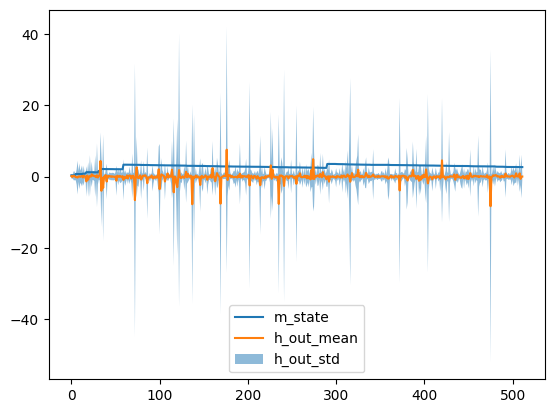

In [9]:
# plot hout + mstate
m_pl = m_out.flatten().cpu().float().numpy()
f_pl = vecF.flatten().cpu().float().numpy()
flogsig_pl = F.logsigmoid(vecF).flatten().cpu().float().numpy()
n_pl = n_out.flatten().cpu().float().numpy()
h_out_pl_mean = h_out.mean(-1).flatten().cpu().float().numpy()
h_out_pl_std = h_out.std(-1).flatten().cpu().float().numpy()
h_out_max = h_out.max(-1)[0].flatten().cpu().float().numpy()
h_out_min = h_out.min(-1)[0].flatten().cpu().float().numpy()
plt.plot(m_pl, label="m_state")
# plt.plot(f_pl, label="f_preact")
# plt.plot(flogsig_pl)
# plt.plot(n_pl, label="n_state")
plt.plot(h_out_pl_mean, label="h_out_mean")
plt.fill_between(
    range(len(h_out_pl_mean)),
    h_out_pl_mean - h_out_pl_std,
    h_out_pl_mean + h_out_pl_std,
    alpha=0.5,
    label="h_out_std",
)
# plt.plot(h_out_max, label="h_out_max")
# plt.plot(h_out_min, label="h_out_min")

plt.legend()
print(f"vecI_offs: {vecI_offset}, vecF_offs: {vecF_offset}")
print(f"S: {S}, B: {B}, NH: {NH}, DHQK: {DHQK}, DHV: {DHV}")
plt.show()

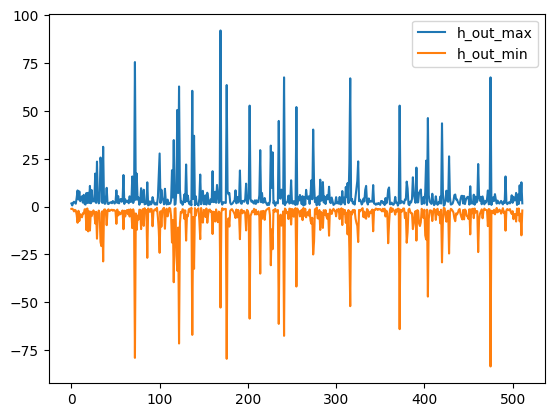

In [10]:
plt.plot(h_out_max, label="h_out_max")
plt.plot(h_out_min, label="h_out_min")
plt.legend()
plt.show()

We see spikes in the standard devation at some time steps. At these timesteps also the max and min spikes. 
Also interesting: we cannot reproduce the linear attention behavior by (constant std / min / max output (scaled input)) setting the gates (input and forget) to 1. Why?


- Question: Do those spikes correlate to the input gate?

Just from these plots, we do not see a strong correlation. Must be also the interaction between q and C or q and k (what is expected). 


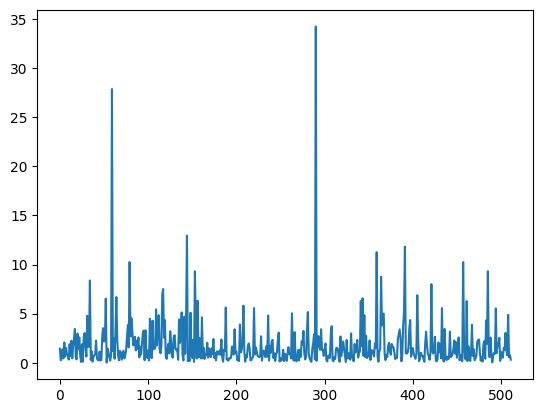

In [11]:
ig_act_pl = torch.exp(vecI).flatten().cpu().float().numpy()
plt.plot(ig_act_pl)
plt.show()

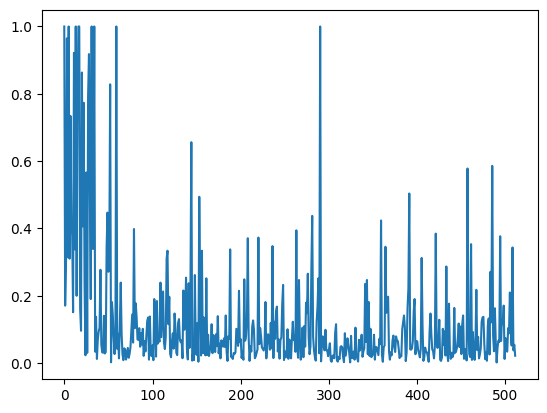

In [12]:
ig_act_pl = torch.exp(vecI - m_out).flatten().cpu().float().numpy()
plt.plot(ig_act_pl)
plt.show()

In [13]:
# causal attention
def causal_attention(q, k, v, mask=None, qk_scale=None, *args, **kwargs):
    if qk_scale is None:
        qk_scale = q.shape[-1] ** 0.5
    q = q / qk_scale
    scores = torch.matmul(q, k.transpose(-2, -1))
    if mask is None:
        mask = torch.ones_like(scores)
        mask = torch.tril(mask)
    scores = scores.masked_fill(mask == 0, float("-inf"))
    scores = F.softmax(scores, dim=-1)
    return torch.matmul(scores, v)

In [14]:
h_att = causal_attention(matQ, matK, matV)

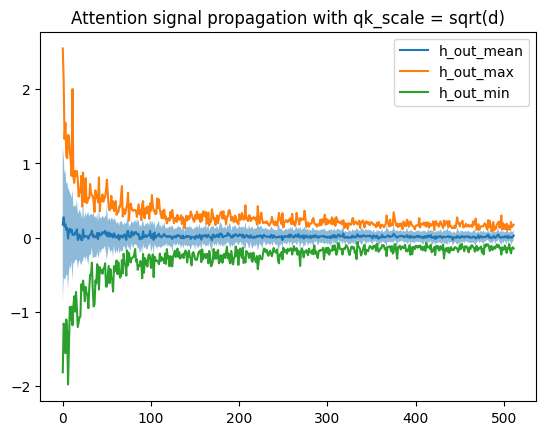

In [15]:
# attention signal propagation with qk_scale = sqrt(d)
h_out_pl_mean = h_att.mean(-1).flatten().cpu().float().numpy()
h_out_pl_std = h_att.std(-1).flatten().cpu().float().numpy()
h_out_max = h_att.max(-1)[0].flatten().cpu().float().numpy()
h_out_min = h_att.min(-1)[0].flatten().cpu().float().numpy()
plt.plot(h_out_pl_mean, label="h_out_mean")
plt.fill_between(
    range(len(h_out_pl_mean)),
    h_out_pl_mean - h_out_pl_std,
    h_out_pl_mean + h_out_pl_std,
    alpha=0.5,
)
plt.plot(h_out_max, label="h_out_max")
plt.plot(h_out_min, label="h_out_min")
plt.title("Attention signal propagation with qk_scale = sqrt(d)")
plt.legend()
plt.show()

In [16]:
h_att = causal_attention(matQ, matK, matV, qk_scale=1.0)

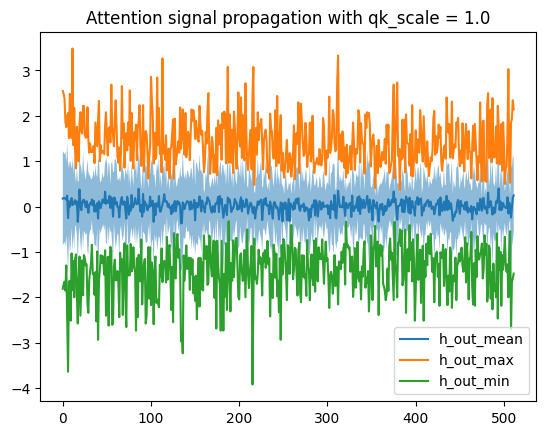

In [17]:
# attention signal propagation with qk_scale = sqrt(d)
h_out_pl_mean = h_att.mean(-1).flatten().cpu().float().numpy()
h_out_pl_std = h_att.std(-1).flatten().cpu().float().numpy()
h_out_max = h_att.max(-1)[0].flatten().cpu().float().numpy()
h_out_min = h_att.min(-1)[0].flatten().cpu().float().numpy()
plt.plot(h_out_pl_mean, label="h_out_mean")
plt.fill_between(
    range(len(h_out_pl_mean)),
    h_out_pl_mean - h_out_pl_std,
    h_out_pl_mean + h_out_pl_std,
    alpha=0.5,
)
plt.plot(h_out_max, label="h_out_max")
plt.plot(h_out_min, label="h_out_min")
plt.title("Attention signal propagation with qk_scale = 1.0")
plt.legend()
plt.show()

In [18]:
def linear_attention_no_act(q, k, v, mask=None, qk_scale=None, *args, **kwargs):
    if qk_scale is None:
        qk_scale = q.shape[-1] ** 0.5
    q = q / qk_scale
    scores = torch.matmul(q, k.transpose(-2, -1))
    if mask is None:
        mask = torch.ones_like(scores)
        mask = torch.tril(mask)
    # scores = scores.masked_fill(mask == 0, float("-inf"))
    # scores = F.softmax(scores, dim=-1)
    return torch.matmul(scores, v)

In [19]:
h_lin_att_no_act = linear_attention_no_act(matQ, matK, matV)

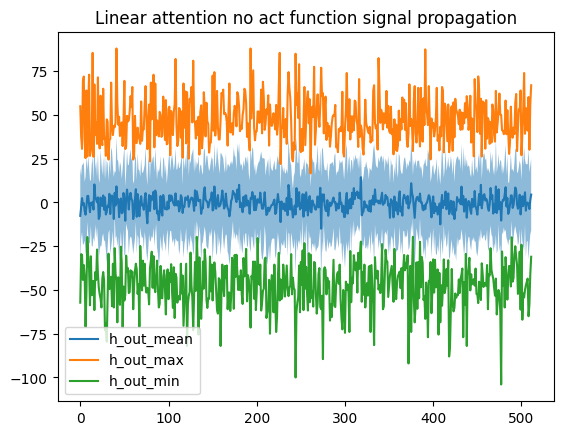

In [20]:
# linear attention no act function signal propagation
h_out_pl_mean = h_lin_att_no_act.mean(-1).flatten().cpu().float().numpy()
h_out_pl_std = h_lin_att_no_act.std(-1).flatten().cpu().float().numpy()
h_out_max = h_lin_att_no_act.max(-1)[0].flatten().cpu().float().numpy()
h_out_min = h_lin_att_no_act.min(-1)[0].flatten().cpu().float().numpy()
plt.plot(h_out_pl_mean, label="h_out_mean")
plt.fill_between(
    range(len(h_out_pl_mean)),
    h_out_pl_mean - h_out_pl_std,
    h_out_pl_mean + h_out_pl_std,
    alpha=0.5,
)
plt.plot(h_out_max, label="h_out_max")
plt.plot(h_out_min, label="h_out_min")
plt.title("Linear attention no act function signal propagation")
plt.legend()
plt.show()

In [21]:
h_lin_att_no_act = linear_attention_no_act(matQ, matK, matV, qk_scale=DHQK)  # qk_scale = d

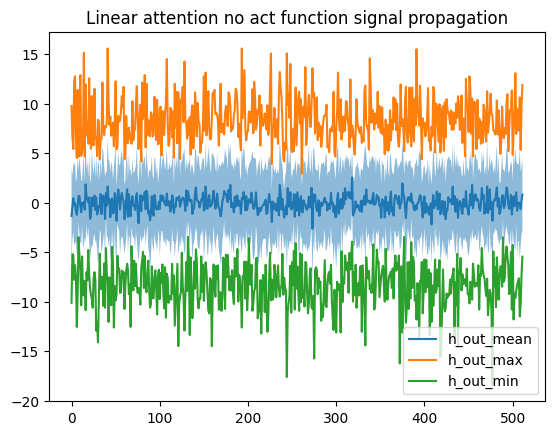

In [22]:
# linear attention no act function signal propagation
h_out_pl_mean = h_lin_att_no_act.mean(-1).flatten().cpu().float().numpy()
h_out_pl_std = h_lin_att_no_act.std(-1).flatten().cpu().float().numpy()
h_out_max = h_lin_att_no_act.max(-1)[0].flatten().cpu().float().numpy()
h_out_min = h_lin_att_no_act.min(-1)[0].flatten().cpu().float().numpy()
plt.plot(h_out_pl_mean, label="h_out_mean")
plt.fill_between(
    range(len(h_out_pl_mean)),
    h_out_pl_mean - h_out_pl_std,
    h_out_pl_mean + h_out_pl_std,
    alpha=0.5,
)
plt.plot(h_out_max, label="h_out_max")
plt.plot(h_out_min, label="h_out_min")
plt.title("Linear attention no act function signal propagation")
plt.legend()
plt.show()

**Conclusion**:
We see indeed the mLSTM operation causes feature spikes, i.e. spiky stddev + max min values per feature dim. 
We compare against causal attention and causal linear attention without q k feature functions. 


Linear attention increases std and it is constant over sequence length. No spikes.

Causal attention decreases the std of the output over sequence length if the qk scale is sqrt(d). No spikes.
If for causal attention the qk scale is set to 1 then there is no decrease in the std of the output over sequence length. 



## Part 2: Modify the mLSTM operation

In [23]:
def make_h_output_plot_mlstm(
    mlstm_func,
    B,
    NH,
    S,
    DHQK,
    DHV,
    vecI_offset,
    vecF_offset,
    igate_init_fn=torch.randn,
    fgate_init_fn=torch.randn,
    seed=0,
    plot_max_min=True,
):
    torch.manual_seed(seed)
    matQ = torch.randn((B, NH, S, DHQK), dtype=DTYPE, device=DEVICE)
    matK = torch.randn((B, NH, S, DHQK), dtype=DTYPE, device=DEVICE)
    matV = torch.randn((B, NH, S, DHV), dtype=DTYPE, device=DEVICE)
    # vecI = 0.00001 * torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)
    # vecF = -30. + torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)
    vecI = vecI_offset + igate_init_fn((B, NH, S), dtype=DTYPE, device=DEVICE)
    vecF = vecF_offset + fgate_init_fn((B, NH, S), dtype=DTYPE, device=DEVICE)

    out = mlstm_func(matQ, matK, matV, vecI, vecF)

    if isinstance(out, tuple):
        h_out, m_out, n_out = out
    else:
        h_out = out
        m_out = None

    # plot hout + mstate
    h_out_pl_mean = h_out.mean(-1).flatten().cpu().float().numpy()
    h_out_pl_std = h_out.std(-1).flatten().cpu().float().numpy()
    h_out_max = h_out.max(-1)[0].flatten().cpu().float().numpy()
    h_out_min = h_out.min(-1)[0].flatten().cpu().float().numpy()
    if m_out is not None:
        m_pl = m_out.flatten().cpu().float().numpy()
        plt.plot(m_pl, label="m_state")
    # plt.plot(f_pl, label="f_preact")
    # plt.plot(flogsig_pl)
    # plt.plot(n_pl, label="n_state")
    plt.plot(h_out_pl_mean, label="h_out_mean")
    plt.fill_between(
        range(len(h_out_pl_mean)),
        h_out_pl_mean - h_out_pl_std,
        h_out_pl_mean + h_out_pl_std,
        alpha=0.5,
    )
    if plot_max_min:
        plt.plot(h_out_max, label="h_out_max")
        plt.plot(h_out_min, label="h_out_min")

    plt.legend()
    print(f"vecI_offs: {vecI_offset}, vecF_offs: {vecF_offset}")
    print(f"S: {S}, B: {B}, NH: {NH}, DHQK: {DHQK}, DHV: {DHV}")
    # plt.yscale("log")
    plt.show()

### 1. Investigate the part with the m state in the denominator

Findings:
- the triton kernels show the same behavior as the torch version. 
- other denominator versions still have feature spikes (i.e. large max min values) even though they are a bit smaller for e.g. for denom_on or exp_minus_m_to_one.

In [24]:
def mlstm_m_state_modify(
    matQ: torch.Tensor,
    matK: torch.Tensor,
    matV: torch.Tensor,
    vecI: torch.Tensor,
    vecF: torch.Tensor,
    eps: float = 1e-6,
    mstate_mode: str = "paper",
) -> torch.Tensor:
    import math

    B, NH, S, DHQK = matQ.shape
    assert matK.shape == (B, NH, S, DHQK)
    assert vecI.shape == (B, NH, S)
    assert vecF.shape == (B, NH, S)

    _dtype, _device = matQ.dtype, matQ.device

    vecLogSigF = F.logsigmoid(vecF)  # (B, NH, S)
    vecLogSigF_cumsum = vecLogSigF.cumsum(-1)

    matLogSigF = vecLogSigF_cumsum[:, :, :, None] - vecLogSigF_cumsum[:, :, None, :]

    ltr = torch.tril(
        torch.ones(
            (S, S),
            dtype=torch.bool,
            device=_device,
        )
    )

    matLogSigF_mask = torch.where(ltr, matLogSigF, -float("inf"))

    matLogD = matLogSigF_mask + vecI[:, :, None, :]

    vecM, _ = torch.max(matLogD, dim=-1, keepdim=True)  # (B, NH, S, 1)
    matLogD_stabilized = matLogD - vecM

    matD = torch.exp(matLogD_stabilized)  # (B, NH, S, S)

    matS = (matQ @ matK.transpose(-2, -1)) / math.sqrt(DHQK)  # (B, NH, S, S)

    matCtilde = matS * matD  # (B, NH, S, S)
    if mstate_mode == "paper":
        vecN = torch.maximum(matCtilde.sum(dim=-1, keepdim=True).abs(), torch.exp(-vecM))  # (B, NH, S, 1)
    elif mstate_mode == "exp_minus_m_to_one":
        vecN = torch.maximum(
            matCtilde.sum(dim=-1, keepdim=True).abs(),
            torch.tensor([1.0], device=_device, dtype=_dtype),
        )  # (B, NH, S, 1)
    elif mstate_mode == "sum_only":
        vecN = matCtilde.sum(dim=-1, keepdim=True).abs()

    elif mstate_mode == "denom_one":
        vecN = torch.tensor([1.0], device=_device, dtype=_dtype)

    else:
        raise ValueError(f"mstate_mode {mstate_mode} not recognized")

    # (B, NH, S, S)
    matC = matCtilde / (vecN + eps)

    matH = matC @ matV  # (B, NH, S, DH)

    return matH, vecM.squeeze(-1), vecN.squeeze(-1)

In [25]:
B = 1
NH = 1
S = 1024
DHQK = 32
DHV = 32
vecI_offset = -3.0
vecF_offset = 10.0

paper version
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


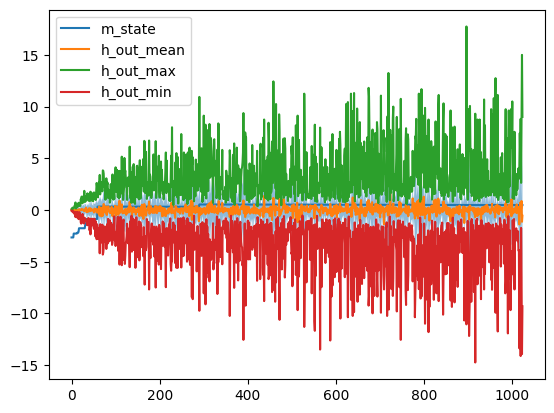

exp_minus_m_to_one
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


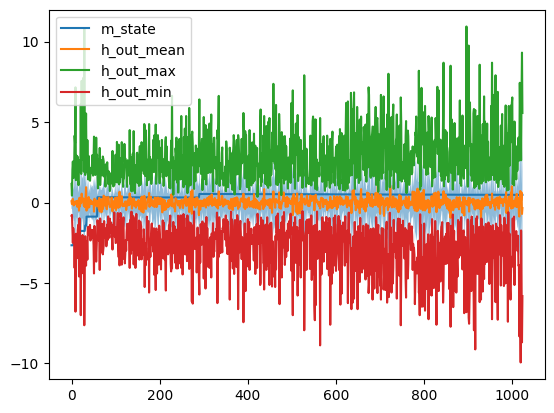

denom_one
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


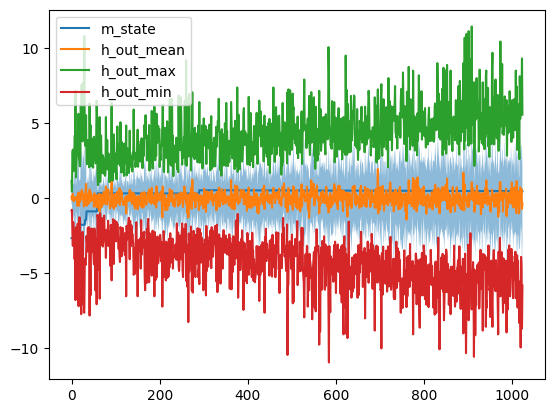

sum_only
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


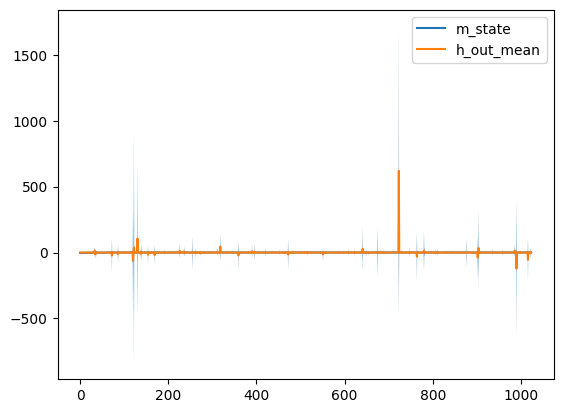

max_chunkwise_triton_v3
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


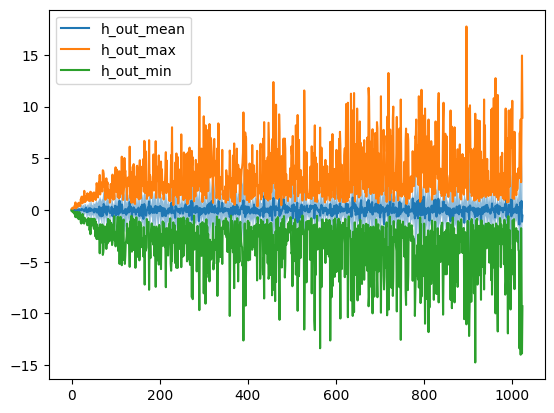

In [26]:
#! randn fgate + randn igate
print("paper version")
make_h_output_plot_mlstm(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="paper"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
)
print("exp_minus_m_to_one")
make_h_output_plot_mlstm(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="exp_minus_m_to_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
)
print("denom_one")
make_h_output_plot_mlstm(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="denom_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
)
print("sum_only")
make_h_output_plot_mlstm(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="sum_only"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    plot_max_min=False,
)
print("max_chunkwise_triton_v3")
make_h_output_plot_mlstm(
    mlstm_func=mlstm_chunkwise_max_triton_v3,
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
)

In [27]:
# The triton kernel shows the same behavior as the paper version

paper version
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


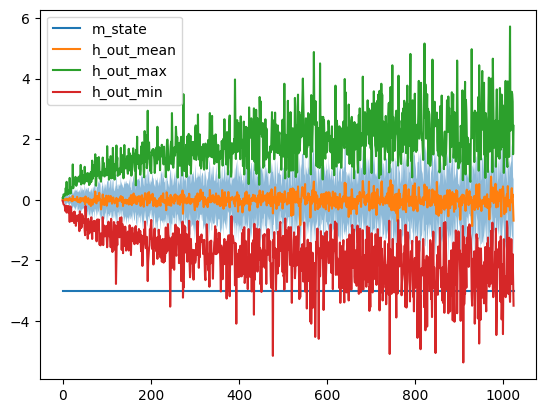

exp_minus_m_to_one
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


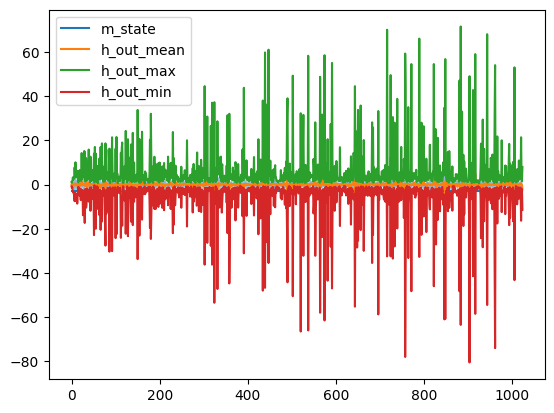

denom_one
vecI_offs: -3.0, vecF_offs: 10.0
S: 1024, B: 1, NH: 1, DHQK: 32, DHV: 32


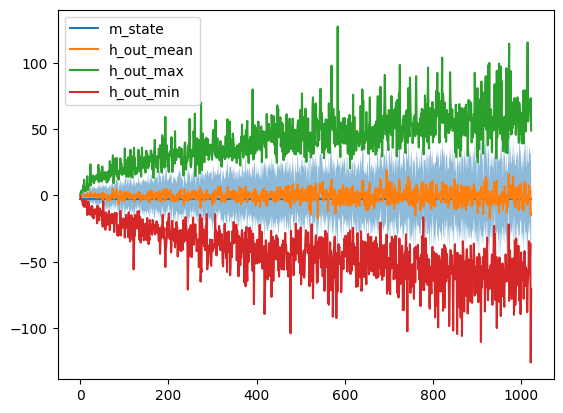

In [28]:
# switch off the input gate
igate_init_fn = torch.zeros
fgate_init_fn = torch.randn

print("paper version")
make_h_output_plot_mlstm(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="paper"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    igate_init_fn=igate_init_fn,
    fgate_init_fn=fgate_init_fn,
)
print("exp_minus_m_to_one")
make_h_output_plot_mlstm(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="exp_minus_m_to_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    igate_init_fn=igate_init_fn,
    fgate_init_fn=fgate_init_fn,
)
print("denom_one")
make_h_output_plot_mlstm(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="denom_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    igate_init_fn=igate_init_fn,
    fgate_init_fn=fgate_init_fn,
)

### 2. Why is the m state so weird

There is some numerical noise / issue with bfloat16. I see a rectancular pattern in matD for eg for bfloat16 which disappiers for float32.
This occurs if you set the vecF_offset to a large negative value.

Another FINDING: if we add a bias to the input gate of -3 then the max min of h are in the same range as of the inputs +-2!!! 
Started experiments at 7B scale with this bias and it seems to reduce gradient spikes, which then might have been caused by the feature spikes.

In [29]:
def mlstm_m_state_modify(
    matQ: torch.Tensor,
    matK: torch.Tensor,
    matV: torch.Tensor,
    vecI: torch.Tensor,
    vecF: torch.Tensor,
    eps: float = 1e-6,
    mstate_mode: str = "paper",
) -> torch.Tensor:
    import math

    B, NH, S, DHQK = matQ.shape
    assert matK.shape == (B, NH, S, DHQK)
    assert vecI.shape == (B, NH, S)
    assert vecF.shape == (B, NH, S)

    _dtype, _device = matQ.dtype, matQ.device

    vecLogSigF = F.logsigmoid(vecF)  # (B, NH, S)
    vecLogSigF_cumsum = vecLogSigF.cumsum(-1)

    matLogSigF = vecLogSigF_cumsum[:, :, :, None] - vecLogSigF_cumsum[:, :, None, :]

    ltr = torch.tril(
        torch.ones(
            (S, S),
            dtype=torch.bool,
            device=_device,
        )
    )

    matLogSigF_mask = torch.where(ltr, matLogSigF, -float("inf"))

    matLogD = matLogSigF_mask + vecI[:, :, None, :]

    vecM, _ = torch.max(matLogD, dim=-1, keepdim=True)  # (B, NH, S, 1)
    matLogD_stabilized = matLogD - vecM

    matD = torch.exp(matLogD_stabilized)  # (B, NH, S, S)

    matS = (matQ @ matK.transpose(-2, -1)) / math.sqrt(DHQK)  # (B, NH, S, S)

    matCtilde = matS * matD  # (B, NH, S, S)
    if mstate_mode == "paper":
        vecN = torch.maximum(matCtilde.sum(dim=-1, keepdim=True).abs(), torch.exp(-vecM))  # (B, NH, S, 1)
    elif mstate_mode == "exp_minus_m_to_one":
        vecN = torch.maximum(
            matCtilde.sum(dim=-1, keepdim=True).abs(),
            torch.tensor([1.0], device=_device, dtype=_dtype),
        )  # (B, NH, S, 1)
    elif mstate_mode == "sum_only":
        vecN = matCtilde.sum(dim=-1, keepdim=True).abs()

    elif mstate_mode == "denom_one":
        vecN = torch.tensor([1.0], device=_device, dtype=_dtype)

    else:
        raise ValueError(f"mstate_mode {mstate_mode} not recognized")

    # (B, NH, S, S)
    matC = matCtilde / (vecN + eps)

    matH = matC @ matV  # (B, NH, S, DH)

    return (
        matH,
        vecM.squeeze(-1),
        vecN.squeeze(-1),
        matLogD,
        matLogD_stabilized,
        matD,
        matCtilde,
        matC,
        vecLogSigF,
        vecLogSigF_cumsum,
    )

In [30]:
def mlstm_stable(
    matQ: torch.Tensor,
    matK: torch.Tensor,
    matV: torch.Tensor,
    vecI: torch.Tensor,
    vecF: torch.Tensor,
    eps: float = 1e-6,
    mstate_mode: str = "paper",
) -> torch.Tensor:
    import math

    B, NH, S, DHQK = matQ.shape
    assert matK.shape == (B, NH, S, DHQK)
    assert vecI.shape == (B, NH, S)
    assert vecF.shape == (B, NH, S)

    _dtype, _device = matQ.dtype, matQ.device

    vecLogSigF = F.logsigmoid(vecF)  # (B, NH, S)

    matLogSigF_tril = vecLogSigF[:, :, :, None].repeat(1, 1, 1, S).tril(-1)
    matLogSigF_cum = matLogSigF_tril.cumsum(-2)

    ltr = torch.tril(
        torch.ones(
            (S, S),
            dtype=torch.bool,
            device=_device,
        )
    )

    matLogSigF_mask = torch.where(ltr, matLogSigF_cum, -float("inf"))

    matLogD = matLogSigF_mask + vecI[:, :, None, :]

    vecM, _ = torch.max(matLogD, dim=-1, keepdim=True)  # (B, NH, S, 1)
    matLogD_stabilized = matLogD - vecM

    matD = torch.exp(matLogD_stabilized)  # (B, NH, S, S)

    matS = (matQ @ matK.transpose(-2, -1)) / math.sqrt(DHQK)  # (B, NH, S, S)

    matCtilde = matS * matD  # (B, NH, S, S)
    if mstate_mode == "paper":
        vecN = torch.maximum(matCtilde.sum(dim=-1, keepdim=True).abs(), torch.exp(-vecM))  # (B, NH, S, 1)
    elif mstate_mode == "exp_minus_m_to_one":
        vecN = torch.maximum(
            matCtilde.sum(dim=-1, keepdim=True).abs(),
            torch.tensor([1.0], device=_device, dtype=_dtype),
        )  # (B, NH, S, 1)
    elif mstate_mode == "sum_only":
        vecN = matCtilde.sum(dim=-1, keepdim=True).abs()

    elif mstate_mode == "denom_one":
        vecN = torch.tensor([1.0], device=_device, dtype=_dtype)

    else:
        raise ValueError(f"mstate_mode {mstate_mode} not recognized")
    # (B, NH, S, S)
    matC = matCtilde / (vecN + eps)

    matH = matC @ matV  # (B, NH, S, DH)

    return (
        matH,
        vecM.squeeze(-1),
        vecN.squeeze(-1),
        matLogD,
        matLogD_stabilized,
        matD,
        matCtilde,
        matC,
        vecLogSigF,
        None,
    )

In [31]:
def make_h_output_plot_mlstm_with_internals(
    mlstm_func,
    B,
    NH,
    S,
    DHQK,
    DHV,
    vecI_offset,
    vecF_offset,
    seed=0,
    plot_max_min=True,
    vecI_init_fn=torch.randn,
    vecF_init_fn=torch.randn,
):
    torch.manual_seed(seed)
    matQ = torch.randn((B, NH, S, DHQK), dtype=DTYPE, device=DEVICE)
    matK = torch.randn((B, NH, S, DHQK), dtype=DTYPE, device=DEVICE)
    matV = torch.randn((B, NH, S, DHV), dtype=DTYPE, device=DEVICE)
    # vecI = 0.00001 * torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)
    # vecF = -30. + torch.randn((B, NH, S), dtype=DTYPE, device=DEVICE)
    vecI = vecI_offset + vecI_init_fn((B, NH, S), dtype=DTYPE, device=DEVICE)
    vecF = vecF_offset + vecF_init_fn((B, NH, S), dtype=DTYPE, device=DEVICE)

    out = mlstm_func(matQ, matK, matV, vecI, vecF)

    if isinstance(out, tuple):
        (
            h_out,
            m_out,
            n_out,
            matLogD,
            matLogD_stabilized,
            matD,
            matCtilde,
            matC,
            vecLogSigF,
            vecLogSigF_cumsum,
        ) = out
    else:
        h_out = out
        m_out = None
        n_out = None
        matLogD = None
        matLogD_stabilized = None
        matD = None
        matCtilde = None
        matC = None
        vecLogSigF = None
        vecLogSigF_cumsum = None

    # plot hout + mstate
    h_out_pl_mean = h_out.mean(-1).flatten().cpu().float().numpy()
    h_out_pl_std = h_out.std(-1).flatten().cpu().float().numpy()
    h_out_max = h_out.max(-1)[0].flatten().cpu().float().numpy()
    h_out_min = h_out.min(-1)[0].flatten().cpu().float().numpy()
    if m_out is not None:
        m_pl = m_out.flatten().cpu().float().numpy()
        plt.plot(m_pl, label="m_state")
    # plt.plot(f_pl, label="f_preact")
    # plt.plot(flogsig_pl)
    # plt.plot(n_pl, label="n_state")
    plt.plot(h_out_pl_mean, label="h_out_mean")
    plt.fill_between(
        range(len(h_out_pl_mean)),
        h_out_pl_mean - h_out_pl_std,
        h_out_pl_mean + h_out_pl_std,
        alpha=0.5,
    )
    if plot_max_min:
        plt.plot(h_out_max, label="h_out_max")
        plt.plot(h_out_min, label="h_out_min")

    plt.legend()
    print(f"vecI_offs: {vecI_offset}, vecF_offs: {vecF_offset}")
    print(f"S: {S}, B: {B}, NH: {NH}, DHQK: {DHQK}, DHV: {DHV}")
    # plt.yscale("log")
    plt.show()

    return (
        h_out,
        m_out,
        n_out,
        matLogD,
        matLogD_stabilized,
        matD,
        matCtilde,
        matC,
        vecLogSigF,
        vecLogSigF_cumsum,
    )

In [32]:
B = 1
NH = 1
S = 8192
D = 1024
DHQK = D
DHV = D
vecI_offset = -5.0  # -3.0
vecF_offset = 6.0
vecI_init_fn = torch.randn
vecF_init_fn = torch.randn

In [33]:
torch.log(torch.sigmoid(torch.tensor([-20.0])))

tensor([-20.])

In [34]:
torch.normal(size=(10, 1), mean=-3, std=0.1)

tensor([[-2.8459],
        [-3.0293],
        [-3.2179],
        [-2.9432],
        [-3.1085],
        [-3.1399],
        [-2.9597],
        [-2.9162],
        [-3.0719],
        [-3.0403]])

In [35]:
F.logsigmoid(torch.tensor([-20.0], device=DEVICE, dtype=torch.float32))

tensor([-20.], device='cuda:0')

paper version
vecI_offs: -5.0, vecF_offs: 6.0
S: 8192, B: 1, NH: 1, DHQK: 1024, DHV: 1024


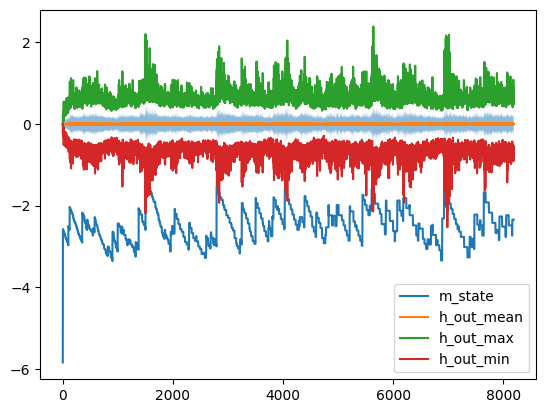

exp_minus_m_to_one
vecI_offs: -5.0, vecF_offs: 6.0
S: 8192, B: 1, NH: 1, DHQK: 1024, DHV: 1024


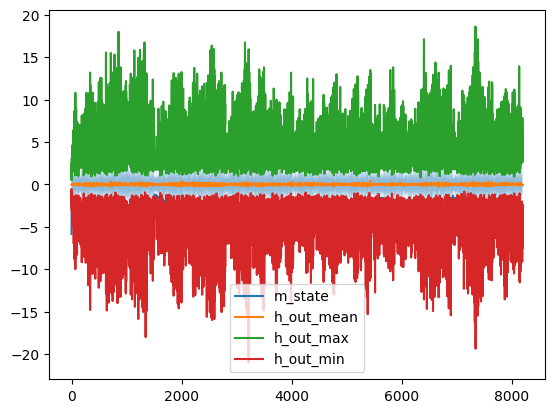

denom_one
vecI_offs: -5.0, vecF_offs: 6.0
S: 8192, B: 1, NH: 1, DHQK: 1024, DHV: 1024


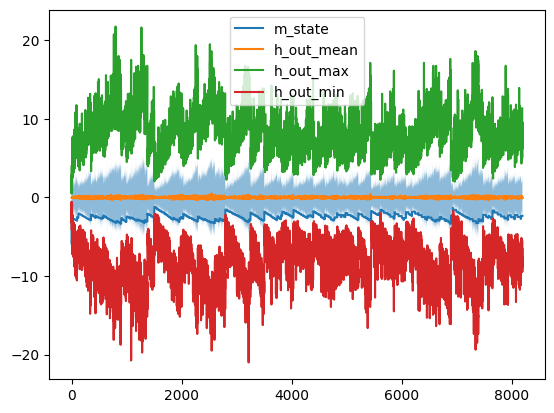

max_triton_v3 kernel
vecI_offs: -5.0, vecF_offs: 6.0
S: 8192, B: 1, NH: 1, DHQK: 1024, DHV: 1024


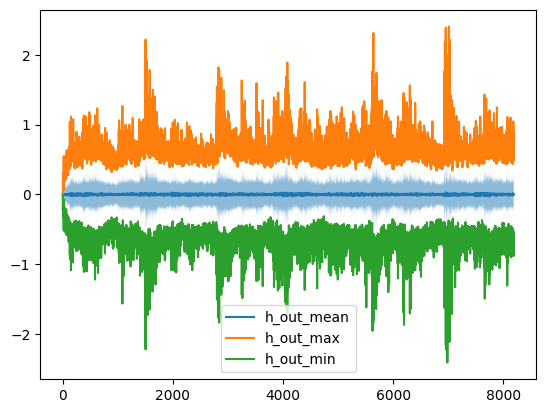

==== stable torch version ====
paper version
vecI_offs: -5.0, vecF_offs: 6.0
S: 8192, B: 1, NH: 1, DHQK: 1024, DHV: 1024


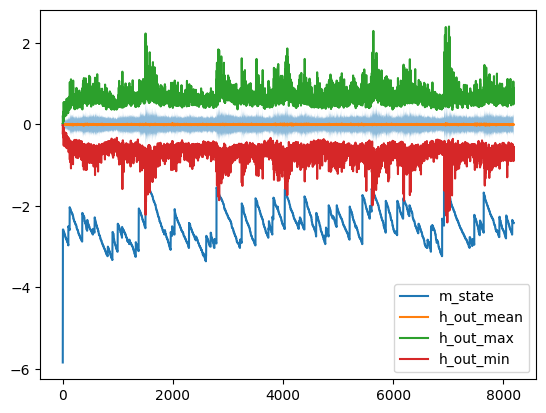

exp_minus_m_to_one
vecI_offs: -5.0, vecF_offs: 6.0
S: 8192, B: 1, NH: 1, DHQK: 1024, DHV: 1024


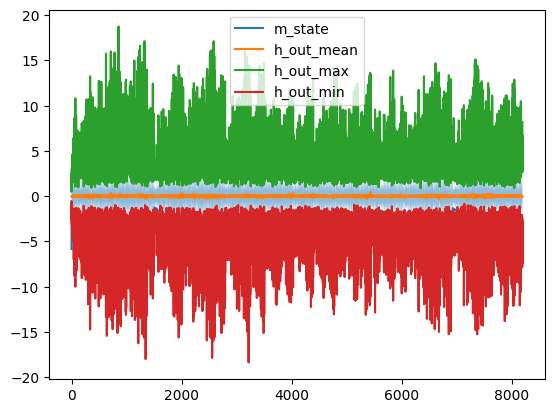

denom_one
vecI_offs: -5.0, vecF_offs: 6.0
S: 8192, B: 1, NH: 1, DHQK: 1024, DHV: 1024


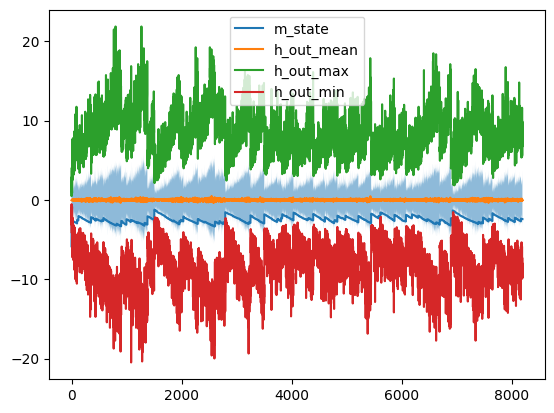

In [36]:
print("paper version")
(
    h_out,
    m_out,
    n_out,
    matLogD,
    matLogD_stabilized,
    matD,
    matCtilde,
    matC,
    vecLogSigF,
    vecLogSigF_cumsum,
) = make_h_output_plot_mlstm_with_internals(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="paper"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    seed=0,
    vecI_init_fn=vecI_init_fn,
    vecF_init_fn=vecF_init_fn,
)
print("exp_minus_m_to_one")
_ = make_h_output_plot_mlstm_with_internals(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="exp_minus_m_to_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    seed=0,
    vecI_init_fn=vecI_init_fn,
    vecF_init_fn=vecF_init_fn,
)
print("denom_one")
(
    h_out_do,
    m_out_do,
    n_out_do,
    matLogD_do,
    matLogD_stabilized_do,
    matD_do,
    matCtilde_do,
    matC_do,
    vecLogSigF_do,
    vecLogSigF_cumsum_do,
) = make_h_output_plot_mlstm_with_internals(
    mlstm_func=partial(mlstm_m_state_modify, mstate_mode="denom_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    seed=0,
    vecI_init_fn=vecI_init_fn,
    vecF_init_fn=vecF_init_fn,
)
print("max_triton_v3 kernel")
_ = make_h_output_plot_mlstm_with_internals(
    mlstm_func=mlstm_chunkwise_max_triton_v3,
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    seed=0,
    vecI_init_fn=vecI_init_fn,
    vecF_init_fn=vecF_init_fn,
)
print("==== stable torch version ====")
print("paper version")
(
    h_out,
    m_out,
    n_out,
    matLogD,
    matLogD_stabilized,
    matD,
    matCtilde,
    matC,
    vecLogSigF,
    vecLogSigF_cumsum,
) = make_h_output_plot_mlstm_with_internals(
    mlstm_func=partial(mlstm_stable, mstate_mode="paper"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    seed=0,
    vecI_init_fn=vecI_init_fn,
    vecF_init_fn=vecF_init_fn,
)
print("exp_minus_m_to_one")
_ = make_h_output_plot_mlstm_with_internals(
    mlstm_func=partial(mlstm_stable, mstate_mode="exp_minus_m_to_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    seed=0,
    vecI_init_fn=vecI_init_fn,
    vecF_init_fn=vecF_init_fn,
)
print("denom_one")
(
    h_out_do,
    m_out_do,
    n_out_do,
    matLogD_do,
    matLogD_stabilized_do,
    matD_do,
    matCtilde_do,
    matC_do,
    vecLogSigF_do,
    vecLogSigF_cumsum_do,
) = make_h_output_plot_mlstm_with_internals(
    mlstm_func=partial(mlstm_stable, mstate_mode="denom_one"),
    B=B,
    NH=NH,
    S=S,
    DHQK=DHQK,
    DHV=DHV,
    vecI_offset=vecI_offset,
    vecF_offset=vecF_offset,
    seed=0,
    vecI_init_fn=vecI_init_fn,
    vecF_init_fn=vecF_init_fn,
)

In [37]:
matLogD[0, 0].shape

torch.Size([8192, 8192])

In [38]:
vabs = 0.01
vmin, vmax = (-vabs, vabs)

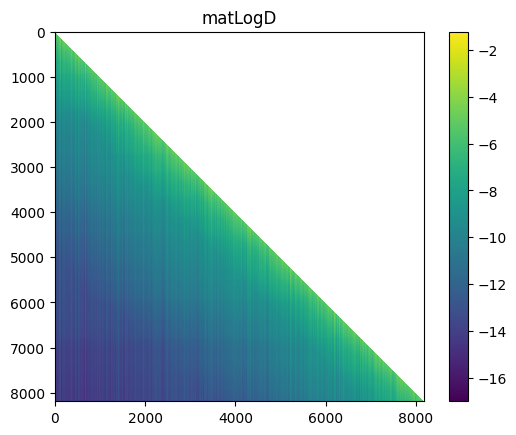

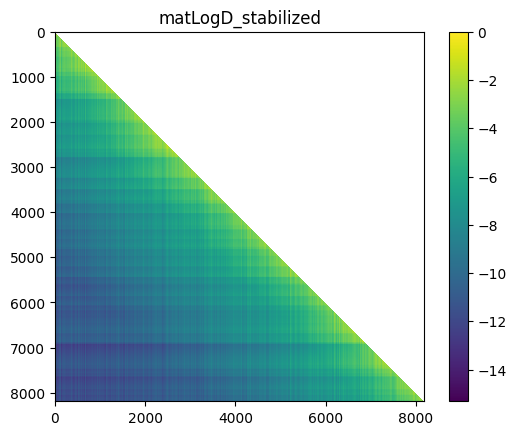

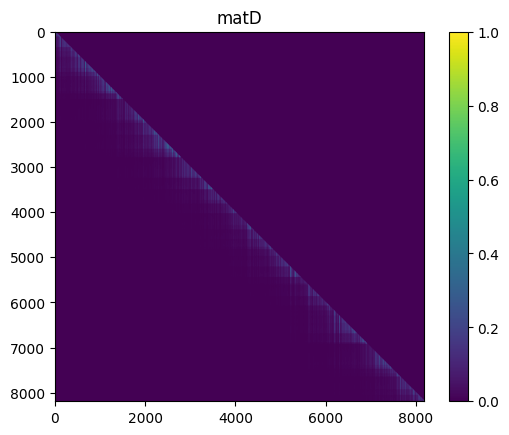

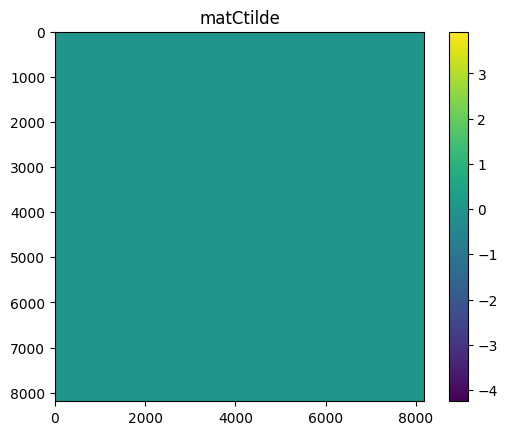

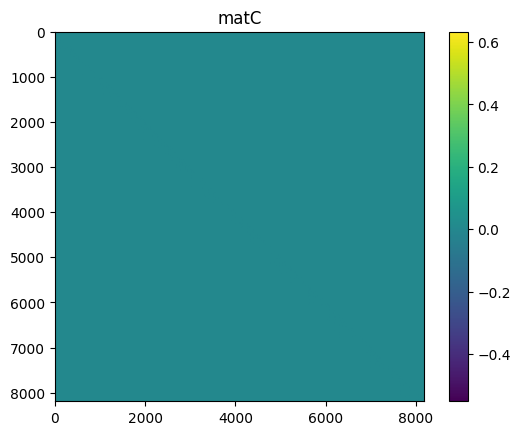

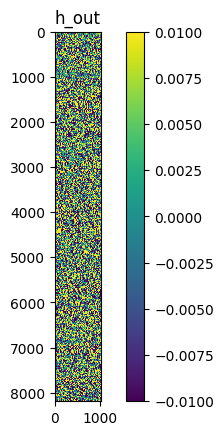

In [39]:
plt.imshow(matLogD[0, 0].float().cpu().numpy())
plt.title("matLogD")
plt.colorbar()
plt.show()
plt.imshow(matLogD_stabilized[0, 0].float().cpu().numpy())
plt.title("matLogD_stabilized")
plt.colorbar()
plt.show()
plt.imshow(matD[0, 0].float().cpu().numpy())
plt.title("matD")
plt.colorbar()
plt.show()
plt.imshow(matCtilde[0, 0].float().cpu().numpy())
plt.title("matCtilde")
plt.colorbar()
plt.show()
plt.imshow(matC[0, 0].float().cpu().numpy())
plt.title("matC")
plt.colorbar()
plt.show()
plt.imshow(h_out[0, 0].float().cpu().numpy(), vmin=vmin, vmax=vmax)
plt.title("h_out")
plt.colorbar()
plt.show()
# plt.imshow(h_out_do[0, 0].float().cpu().numpy(), vmin=vmin, vmax=vmax)
# plt.title("h_out denom_one")
# plt.colorbar()
# plt.show()

In [40]:
matLogD[0, 0, 238:, 237:]

tensor([[ -5.9688,  -3.8281,     -inf,  ...,     -inf,     -inf,     -inf],
        [ -5.9688,  -3.8281,  -4.5938,  ...,     -inf,     -inf,     -inf],
        [ -5.9688,  -3.8281,  -4.5938,  ...,     -inf,     -inf,     -inf],
        ...,
        [-15.2500, -13.0625, -13.8750,  ...,  -2.5625,     -inf,     -inf],
        [-15.2500, -13.0625, -13.8750,  ...,  -2.5625,  -6.1875,     -inf],
        [-15.2500, -13.0625, -13.8750,  ...,  -2.5625,  -6.1875,  -6.1250]], device='cuda:0', dtype=torch.bfloat16)

In [41]:
F.logsigmoid(vecF).shape

torch.Size([1, 1, 512])

In [42]:
vecM, vecM_idxes = torch.max(matLogD, dim=-1, keepdim=True)  # (B, NH, S, 1)

In [43]:
vecM_idxes

tensor([[[[   0],
          [   1],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          [   2],
          

In [44]:
vecM

tensor([[[[-5.8438],
          [-4.0312],
          [-2.5781],
          [-2.5781],
          [-2.5781],
          [-2.5781],
          [-2.5781],
          [-2.5938],
          [-2.5938],
          [-2.5938],
          [-2.5938],
          [-2.5938],
          [-2.6094],
          [-2.6094],
          [-2.6250],
          [-2.6250],
          [-2.6250],
          [-2.6406],
          [-2.6406],
          [-2.6406],
          [-2.6406],
          [-2.6562],
          [-2.6562],
          [-2.6562],
          [-2.6562],
          [-2.6562],
          [-2.6562],
          [-2.6719],
          [-2.6719],
          [-2.6719],
          [-2.6719],
          [-2.6875],
          [-2.6875],
          [-2.6875],
          [-2.7031],
          [-2.7031],
          [-2.7031],
          [-2.7031],
          [-2.7031],
          [-2.7031],
          [-2.7188],
          [-2.7188],
          [-2.7188],
          [-2.7344],
          [-2.7344],
          [-2.7500],
          [-2.7500],
          [-2